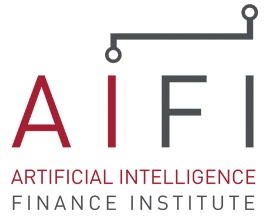


# Bootcamp - Python and Coding - Supervised Machine Learning


# About this Notebook


## Understanding Memory Layout in NumPy, sklearn, PyTorch and TensorFlow


When creating multi-dimensional arrays in NumPy, we can choose between two types of memory layout:

- __C-style (Row-major order)__: This is the default order of NumPy, where the array elements are stored such that the rightmost index 'changes the fastest'. As a result, in a 2D array, each row is a contiguous block in memory. This layout is typically more efficient for operations that work primarily on rows, such as certain types of matrix multiplications, as it enables efficient use of cache memory. This is also the default layout used by sklearn and PyTorch.

- __Fortran-style (Column-major order)__: In this order, the leftmost index 'changes the fastest'. Therefore, in a 2D array, each column is a contiguous block in memory. This layout can be beneficial when performing operations that work primarily on columns. In the context of GPU computations, particularly with TensorFlow, this layout is often used due to specific advantages it offers in such scenarios.

In this notebook, we will create arrays using both these layouts, perform matrix multiplications, and use the SVM model of sklearn to understand the differences in computational efficiency. We will also profile a PyTorch model to understand how memory layout affects its performance. In the end, we'll touch upon the specifics of memory layout in the context of TensorFlow.

Remember, understanding the memory layout is important as it can significantly impact the efficiency of your numerical computations and machine learning models.

### Memory Layout in sklearn
Just like __NumPy, scikit-learn__ can also handle data arrays in both __C-style__ and __Fortran-style__ memory layouts. However, it's important to note that scikit-learn assumes that input data is in C-style (row-major) format. While it can handle Fortran-style inputs, it might lead to unexpected results or inefficiencies.

We will compare the time taken to train a support vector machine (SVM) model with a linear kernel on data arrays with both memory layouts. This will help us understand the impact of memory layout on the performance of machine learning models in scikit-learn.


### Memory Layout in PyTorch and TensorFlow
Both PyTorch and TensorFlow are primarily used for deep learning tasks, where computations are frequently offloaded to GPUs. These libraries use a layout optimized for GPU computations and high-dimensional tensors, making them slightly different from NumPy and sklearn.

- __PyTorch__: PyTorch assumes that data is laid out in row-major order (similar to NumPy and sklearn). Meaning it uses the C-style order for its multi-dimensional arrays known as tensors. This choice aligns with the standard layout used by C and C++, and hence the CUDA kernels provided by NVIDIA for GPU-accelerated computation. In contrast to TensorFlow, PyTorch does not typically design its own CUDA kernels or perform complex transformations on the data. Instead, it can directly use the optimized CUDA kernels, which are inherently compatible with the row-major layout. Additionally, the C-style layout consistency between CPU and GPU memory allows tensors to be moved seamlessly between the two, minimizing the need for data transformations and enhancing computational efficiency. 



- However, PyTorch does implement custom CUDA kernels for specific operations where it sees a benefit in performance or flexibility that is not covered by cuDNN or where custom kernels can provide better integration with PyTorch's dynamic computation graph. These custom kernels are developed with PyTorch's design goals in mind, aiming to balance performance with the framework's emphasis on ease of use, flexibility, and dynamism. 


- PyTorch's approach to CUDA optimization is also influenced by its support for dynamic computation graphs (also known as define-by-run approach), where the graph of operations is built on-the-fly as operations are executed. This contrasts with TensorFlow's traditional static graph approach (though TensorFlow 2.x has embraced eager execution as well). The dynamic nature of PyTorch allows for more Pythonic control flow and easier debugging at the expense of potential optimizations that can be achieved with static graphs.


In this notebook, we will explore the implications of these choices on performance in PyTorch.

- __TensorFlow__ While TensorFlow follows a row-major (C-style) layout at the higher level, many of the underlying libraries it uses for computations (such as Eigen) are optimized for column-major (Fortran-style) layout. However, TensorFlow is designed to handle these intricacies for you. The library manages its own memory, designs its own CUDA kernels, and performs a myriad of optimizations under the hood. For instance, TensorFlow may automatically transpose a matrix before an operation to benefit from faster column-wise access. As a user, you generally don't have to worry about the memory layout of your tensors when working with TensorFlow's high-level APIs - TensorFlow's internal mechanisms will manage the most efficient organization of data for you.

In both cases, being aware of how these libraries handle memory layout can be beneficial in writing efficient, optimized deep learning code. Especially in the domain of finance, where models often have to deal with large amounts of high-dimensional data, these performance considerations can play a crucial role.


However, given that PyTorch and the GPU both utilize a C-style (row-major) memory layout, this can potentially lead to more efficient data transfer between the CPU and GPU, as no transformations are needed to adjust the memory layout. Therefore, if you were to profile the data transfer between the CPU and GPU using NVIDIA's profiling tools (such as NVIDIA Nsight or the NVIDIA Visual Profiler), you might observe more efficient transfers in PyTorch due to this consistency in memory layout.


### Why should you care about memory access?

The way memory is accessed in C-style layout aligns with how cache systems work in modern computer architectures, i.e., enhancing temporal and spatial locality of reference. Temporal locality refers to the reuse of specific data, and/or resources, within a relatively small time duration. Spatial locality refers to the use of data elements within relatively close storage locations. Sequential access in row-major order (C-style) is typically faster due to prefetching and fewer cache misses.

### Concept of tiled matrix multiplication

Tiled matrix multiplication is an optimization technique used in GPU computations where the matrices are divided into sub-matrices or 'tiles'. These tiles are loaded into the faster shared memory of the GPU in chunks, and each thread calculates a separate element of the resulting tile, which maximizes parallel computation and minimizes memory access latency, thereby speeding up the overall matrix multiplication operation.

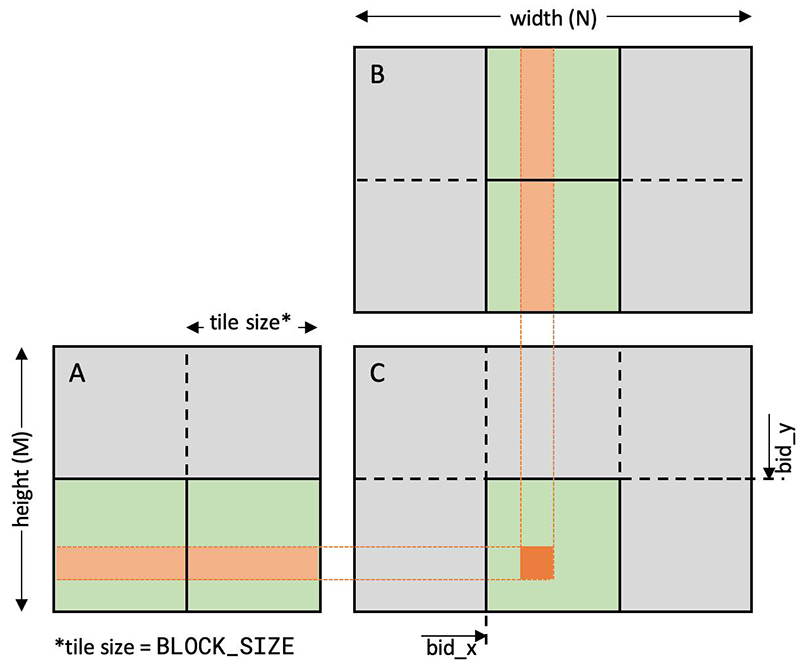


In the C-style memory layout, accessing memory in a row-wise manner results in contiguous memory accesses, which is an ideal situation for GPUs. When we perform matrix multiplication, accessing the rows of the first matrix and the columns of the second one in a contiguous manner enables the best use of shared memory on the GPU. Hence, the C-style memory layout allows tiled matrix multiplication to be efficient.

The tiled matrix multiplication works well with this memory layout because it loads small square 'tiles' from the global memory to the faster shared memory, and each thread computes a separate element of the resulting tile. This approach efficiently uses the GPU architecture to speed up computations.

# Row major vs. column major order


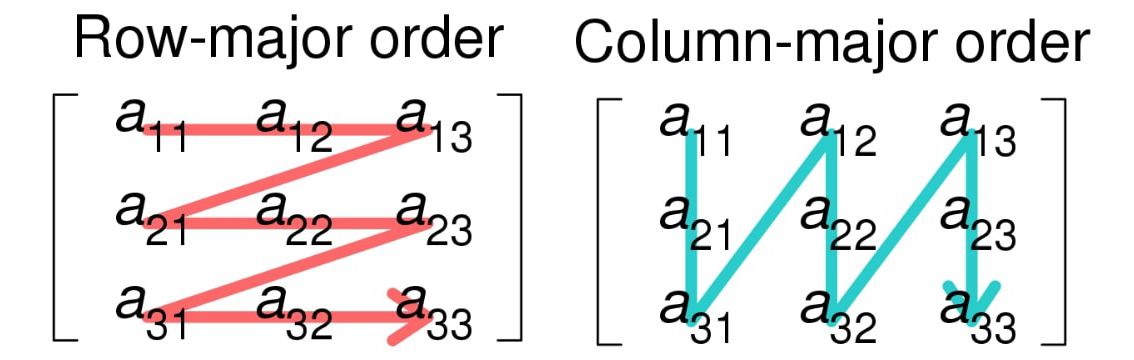

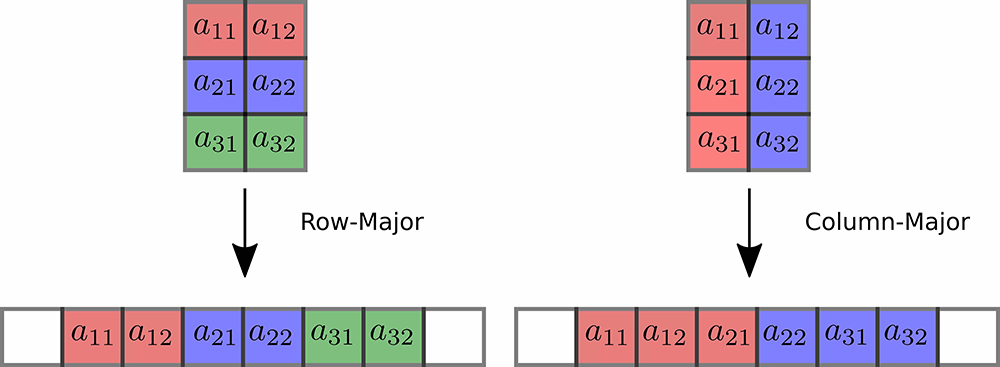

By default, NumPy arranges the data in row-major order, like in C. Row-major order lays out the entries of the array by groupings of rows. An alternative is column-major ordering, as used in Fortran and MATLAB, which uses columns as the grouping. NumPy is capable of implementing both ordering schemes by passing the keyword order when creating an array. See the figure below for the differeneces in the schemes.

## Why does this matter? - Memory storage

- In row-major order, elements of a matrix are stored by rows which aligns with the way CPU caches work. When a CPU accesses a specific memory location, it also loads adjacent memory locations into the cache, anticipating that these will be accessed next. Since elements in the same row of a matrix are stored adjacently in memory in row-major order, this reduces cache misses and increases performance when accessing the matrix row-wise. 

In [ ]:
# Create arrays
c_array = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.int64, order='C')
f_array = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.int64, order='F')

# Print elements in memory order
# order='K' = > NumPy will choose the most efficient way to iterate over the array based on its memory layout
print("C-style order:", [int(x) for x in np.nditer(c_array, order='K')])
print("Fortran-style order:", [int(x) for x in np.nditer(f_array, order='K')])


C-style order: [1, 2, 3, 4, 5, 6]
Fortran-style order: [1, 4, 2, 5, 3, 6]


Using order='K' with np.nditer tells NumPy to iterate over the elements of the array following the storage order of the array itself, which can be particularly useful for arrays that do not have a standard memory layout due to slicing, transposing, or other operations.

- In contrast, elements in the same column of the matrix are not stored adjacently in memory in column-major order, leading to more cache misses and slower performance when accessed row-wise. However, when data is accessed column-wise, column-major order would be more efficient for the same reasons.


Both holds true for using a GPU. 

# Imports

In [ ]:
from sklearn.svm import SVC
import numpy as np
import time
import torch
from transformers import BertModel, BertTokenizer
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
# Create large arrays in C-style and Fortran-style order
size = 5000
c_array = np.random.rand(size, size)
f_array = np.asfortranarray(c_array)

# Time a NumPy matrix multiplication operation on the two arrays
start = time.time()
np.dot(c_array, c_array.T)
print("C-style matrix multiplication time:", time.time() - start)

start = time.time()
np.dot(f_array, f_array.T)
print("Fortran-style matrix multiplication time:", time.time() - start)


C-style matrix multiplication time: 3.7591891288757324
Fortran-style matrix multiplication time: 5.151366233825684


In [ ]:
# Create large 2D arrays in C-style and Fortran-style order
size = 5000
X = np.random.rand(size, size)
Y = np.random.randint(2, size=size)
c_array_X = np.array(X, order='C')
c_array_Y = np.array(Y, order='C')
f_array_X = np.array(X, order='F')
f_array_Y = np.array(Y, order='F')

# Time a SVC fit operation on the two arrays
start = time.time()
clf = SVC(kernel='linear', random_state=0)
clf.fit(c_array_X, c_array_Y)
print("C-style fit time:", time.time() - start)

start = time.time()
clf = SVC(kernel='linear', random_state=0)
clf.fit(f_array_X, f_array_Y)
print("Fortran-style fit time:", time.time() - start)


C-style fit time: 117.71408319473267
Fortran-style fit time: 118.29795050621033


In [ ]:
# Create arrays in row-major and column-major order
c_array = np.array([[1, 2, 3], [4, 5, 6]], order='C')
f_array = np.array([[1, 2, 3], [4, 5, 6]], order='F')

# Check the 'C_CONTIGUOUS' (row-major) and 'F_CONTIGUOUS' (column-major) flags
print("C-style array is row-major:", c_array.flags['C_CONTIGUOUS'])
print("C-style array is column-major:", c_array.flags['F_CONTIGUOUS'])

print("Fortran-style array is row-major:", f_array.flags['C_CONTIGUOUS'])
print("Fortran-style array is column-major:", f_array.flags['F_CONTIGUOUS'])


C-style array is row-major: True
C-style array is column-major: False
Fortran-style array is row-major: False
Fortran-style array is column-major: True


In [ ]:
c_array

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
f_array

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
x = torch.randn((1, 3, 224, 224)).cuda()
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True).cuda()
model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)

print(prof.key_averages().table(sort_by="cuda_time_total"))


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.5MB/s]


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         1.67%      23.969ms       100.00%        1.437s        1.437s       0.000us         0.00%       8.842ms       8.842ms             1  
                                      aten::convolution         0.22%       3.091ms        84.25%        1.211s      22.843ms       0.000us         0.00%       7.447ms     140.509us            53  
         

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model and tokenizer (Bert-base)
model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode some text
input_text = "Here is some text to encode"
encoded_input = tokenizer.encode_plus(input_text, return_tensors='pt').to(device)

model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        outputs = model(**encoded_input)

print(prof.key_averages().table(sort_by="cuda_time_total"))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         3.32%      12.493ms        99.99%     376.280ms     376.280ms       0.000us         0.00%       6.337ms       6.337ms             1  
                                           aten::linear         0.26%     960.000us        10.87%      40.903ms     560.315us       0.000us         0.00%       5.411ms      74.123us            73  
         